# Electricity Demand Forecasting


Time Series Modeling<br>
In this project I am exploring time series modeling for Electricity Demand Forecasting for the state of California.

In this notebook I investigate the use the the Facebook Prophet Model.  The original paper describing the model can be found here in the article <a href='https://peerj.com/preprints/3190/'>Forecasting At Scale</a>.  This notebook uses the weekly demand data for California electricity demand generated using the notebook EF_EDA_CleanSplitAgg.ipynb.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Module Import](#'import')<br>
2. [Data Import](#'read_data')<br>
    2A. [Data Split](#'data_split')<br>
3. [Modeling](#'modeling')<br>
4. [Walk Forward Validataion](#'wfvalidate')<br> 
    4A. [Walk Forward Validataion - Step 1](#'wfvalidate_step1')<br> 
    4B. [Walk Forward Validataion - Step 2](#'wfvalidate_step2')<br> import pandas as pd
import numpy as np

from fbprophet import Prophet
import matplotlib.pyplot as plt

----
### <a id='import'> 1. Module Import </a>

Import the modules used in this notebook.

----

In [8]:
import pandas as pd
import numpy as np

from fbprophet import Prophet
import matplotlib.pyplot as plt

In [51]:
elec_df = pd.read_csv('../data/big_demand_temp_train.csv', index_col=0)
elec_df.index = [x.split('+')[0] for x in elec_df.index]
elec_df.index = pd.DatetimeIndex(elec_df.index)
elec_df.index.tz_localize(None)
elec_df.rename({'demand' : 'y'}, axis=1, inplace=True)
elec_df['ds'] = elec_df.index.tz_localize(None)
elec_df.head()

,y,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW,ds
2015-07-01 08:00:00,38210,71.60,68.76,70.89,59.32,79.80,86.04,13845790.0,0,0,1,0,0,0,0,2,2015-07-01 08:00:00
2015-07-01 09:00:00,35171,70.93,68.19,69.78,58.96,77.77,86.35,13845790.0,0,0,1,0,0,0,0,2,2015-07-01 09:00:00
2015-07-01 10:00:00,33243,70.43,68.29,68.07,58.63,76.51,82.74,13845790.0,0,0,1,0,0,0,0,2,2015-07-01 10:00:00
2015-07-01 11:00:00,31955,70.87,68.32,66.92,58.11,74.94,82.04,13845790.0,0,0,1,0,0,0,0,2,2015-07-01 11:00:00
2015-07-01 12:00:00,31199,71.58,68.46,66.16,57.90,73.80,80.37,13845790.0,0,0,1,0,0,0,0,2,2015-07-01 12:00:00


In [52]:
X_train = elec_df.iloc[:28000, :]
X_test = elec_df.iloc[28000:, :]

In [53]:
train_len = int(0.7 * elec_df.shape[0])
window_len = int(0.1 * elec_df.shape[0])

In [54]:
# Make the primary train/validation split
X_train = elec_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = elec_df.iloc[train_len:train_len+window_len, :]
X_walk2 = elec_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = elec_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [56]:
# Configure the base model with the correct seasonality terms
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Add the exogenous regressors
m.add_regressor('Los Angeles')
m.add_regressor('San Diego')
m.add_regressor('Fresno')
m.add_regressor('Mon')
m.add_regressor('Tue')
m.add_regressor('Wed')
m.add_regressor('Thur')
m.add_regressor('Fri')
m.add_regressor('Sat')

# Train the model on using the training dataset
m.fit(X_train)

In [57]:
# Use the first walk forward validation block time for a prediction
future=X_walk1.loc[:, 'Los Angeles':'ds']

In [58]:
# Get the actual forecast data
forecast = m.predict(future)
forecast.index = pd.DatetimeIndex(forecast['ds'])

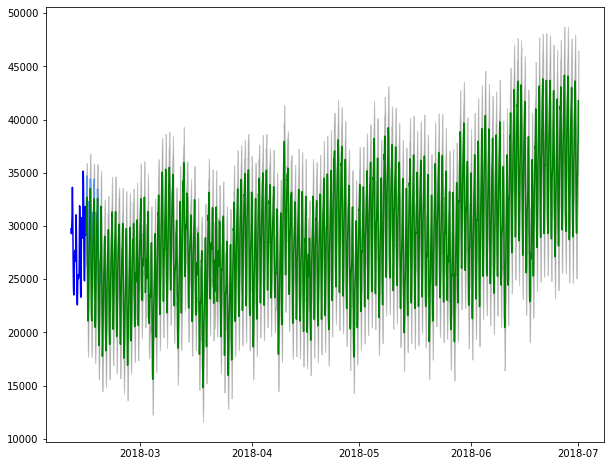

In [59]:
fig = plt.figure(figsize=[10,8])


plt.plot(X_walk1.index[:100], X_walk1['y'].values[:100], c='cornflowerblue')
plt.plot(X_train.index[-100:], X_train['y'].values[-100:], c='b')
plt.plot(forecast['ds'].values, forecast['yhat'].values, c='g')

plt.fill_between(forecast['ds'].values, forecast['yhat_lower'].values, forecast['yhat_upper'].values, color='k', alpha=0.2)

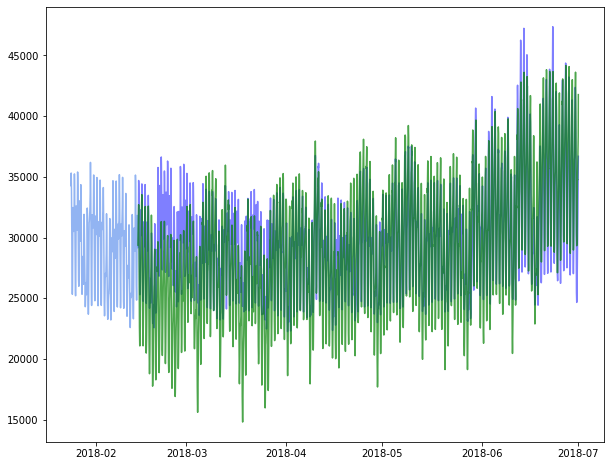

In [60]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk1.index, X_walk1['y'].values, c='b', alpha=0.5)
plt.plot(X_train.index[-500:], X_train['y'].values[-500:], c='cornflowerblue', alpha=0.7)
plt.plot(forecast.index, forecast['yhat'].values, c='green', alpha=0.7)

In [61]:
residuals = [abs(X_walk1.loc[x, 'y'] - forecast.loc[x, 'yhat'])/ \
             X_walk1.loc[x, 'y'] * 100 for x in forecast.index]
timestamps = [int(x.timestamp()) for x in forecast.index]
z = np.polyfit(timestamps, residuals, 3)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

In [62]:
mape = np.mean(residuals[:3*168])
print(mape)

14.309159126952153


(0, 50)

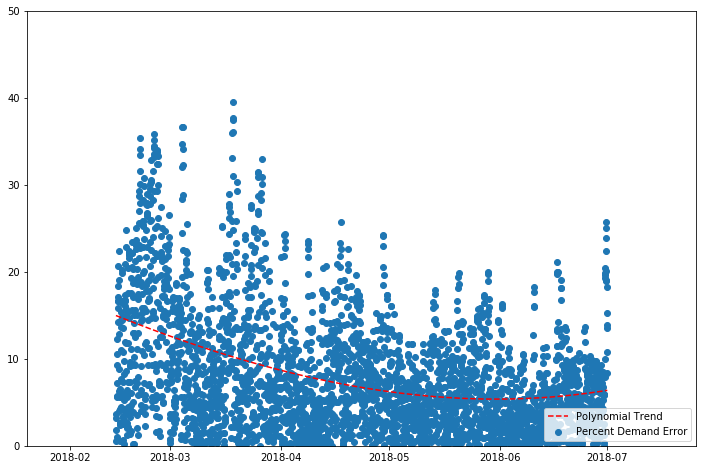

In [63]:
fig = plt.figure(figsize=[12,8])
plt.scatter(forecast.index, residuals, label='Percent Demand Error')
plt.plot(forecast.index, trend,"r--", label='Polynomial Trend')
plt.legend(loc='lower right')
plt.ylim(0, 50)

In [20]:
X_train = X_train.append(X_walk1)

In [21]:
m2 = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m2.add_regressor('Los Angeles')
m2.add_regressor('San Diego')
m2.add_regressor('Fresno')
m2.add_regressor('Mon')
m2.add_regressor('Tue')
m2.add_regressor('Wed')
m2.add_regressor('Thur')
m2.add_regressor('Fri')
m2.add_regressor('Sat')
m2.fit(X_train)

In [22]:
future2=X_walk2.loc[:, 'Los Angeles':'ds']

In [25]:
forecast2 = m2.predict(future2)
forecast2.index = pd.DatetimeIndex(forecast2['ds'])

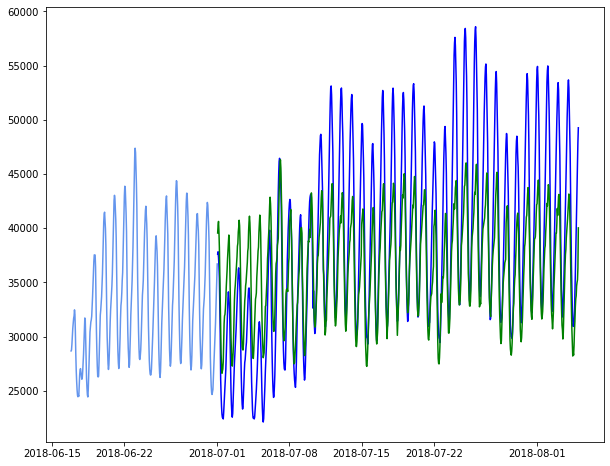

In [26]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk2.index[:5*168], X_walk2['y'].values[:5*168], c='b', label='Validation Data')
plt.plot(X_train.index[-2*168:], X_train['y'].values[-2*168:], c='cornflowerblue', label='Training Data')
plt.plot(forecast2.index[:5*168], forecast2['yhat'].values[:5*168], c='green', label='Forecast')

In [28]:
residuals = [abs(X_walk2.loc[x, 'y'] - forecast2.loc[x, 'yhat'])/ \
             X_walk2.loc[x, 'y'] * 100 for x in forecast2.index]
timestamps = [int(x.timestamp()) for x in forecast2.index]
z = np.polyfit(timestamps, residuals, 3)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

In [29]:
mape = np.mean(residuals[:3*168])
print(mape)

11.382252554698594


(0, 50)

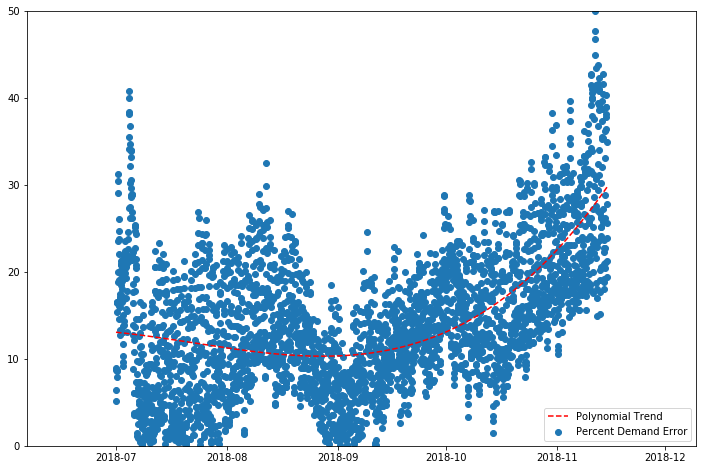

In [30]:
fig = plt.figure(figsize=[12,8])
plt.scatter(forecast2.index, residuals, label='Percent Demand Error')
plt.plot(forecast2.index, trend,"r--", label='Polynomial Trend')
plt.legend(loc='lower right')
plt.ylim(0, 50)

In [31]:
X_train = X_train.append(X_walk2)

In [33]:
m3 = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m3.add_regressor('Los Angeles')
m3.add_regressor('San Diego')
m3.add_regressor('Fresno')
m3.add_regressor('Mon')
m3.add_regressor('Tue')
m3.add_regressor('Wed')
m3.add_regressor('Thur')
m3.add_regressor('Fri')
m3.add_regressor('Sat')
m3.fit(X_train)

In [34]:
future2=X_walk3.loc[:, 'Los Angeles':'ds']

In [35]:
forecast3 = m3.predict(future2)
forecast3.index = pd.DatetimeIndex(forecast3['ds'])

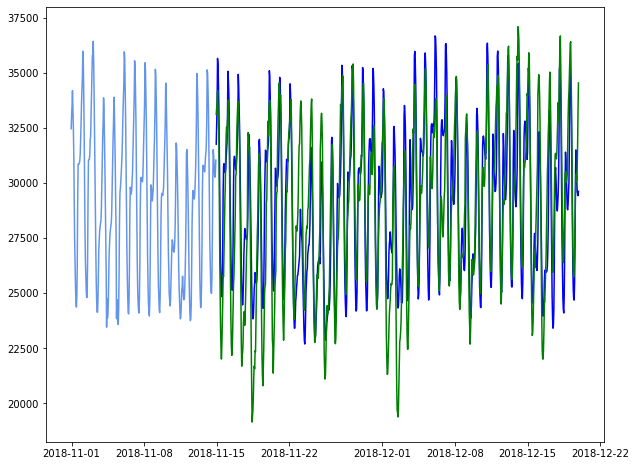

In [36]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk3.index[:5*168], X_walk3['y'].values[:5*168], c='b', label='Validation Data')
plt.plot(X_train.index[-2*168:], X_train['y'].values[-2*168:], c='cornflowerblue', label='Training Data')
plt.plot(forecast3.index[:5*168], forecast3['yhat'].values[:5*168], c='green', label='Forecast')

In [42]:
residuals = [abs(X_walk3.loc[x, 'y'] - forecast3.loc[x, 'yhat'])/ \
             X_walk3.loc[x, 'y'] * 100 for x in forecast3.index]
timestamps = [int(x.timestamp()) for x in forecast3.index]
z = np.polyfit(timestamps, residuals, 3)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

In [43]:
mape = np.mean(residuals[:3*168])
print(mape)

6.304354367312497


(0, 50)

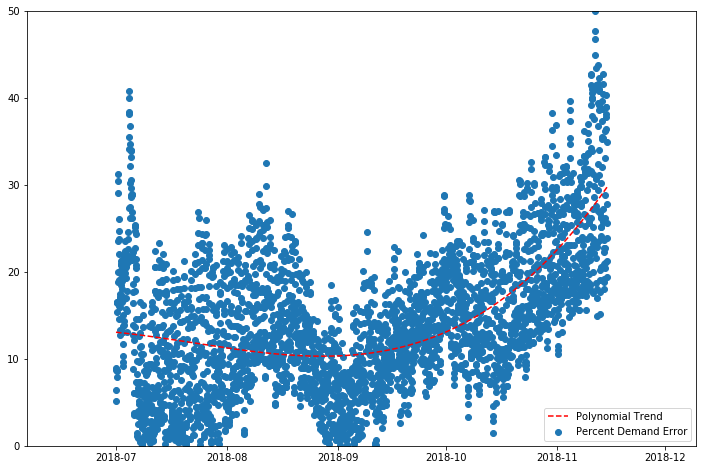

In [39]:
fig = plt.figure(figsize=[12,8])
plt.scatter(forecast2.index, residuals, label='Percent Demand Error')
plt.plot(forecast2.index, trend,"r--", label='Polynomial Trend')
plt.legend(loc='lower right')
plt.ylim(0, 50)

(array([434., 814., 875., 670., 290., 118.,  44.,  34.,   3.,   4.]),
 array([2.97175912e-02, 5.51011103e+00, 1.09905045e+01, 1.64708979e+01,
        2.19512913e+01, 2.74316848e+01, 3.29120782e+01, 3.83924716e+01,
        4.38728651e+01, 4.93532585e+01, 5.48336519e+01]),
 <a list of 10 Patch objects>)

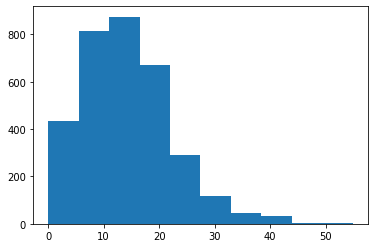

In [40]:
plt.hist(residuals)